In [2]:
# pytorch
import torch
from torch import nn

import torchmetrics

# computer vision
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

# data charting
import matplotlib.pyplot as plt

# time
from timeit import default_timer as timer

In [3]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

- FashionMNIST dataset with total of 70,000 data points and 10 classes.

- Each image is a gray-scale 28 x 28 image.

- Used to classify different items of clothing.

In [4]:
# Downloading the data
train_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None,
)

test_data = torchvision.datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None,
)

In [5]:
# Classes of our data
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
# Checking shape and labels
image, label = train_data[0]

print(image.shape)                      # color channels, height, width
print()
print(train_data.classes[label])        # the label for the image
print()
print(image.shape[1] * image.shape[2])  # height * width

torch.Size([1, 28, 28])

Ankle boot

784


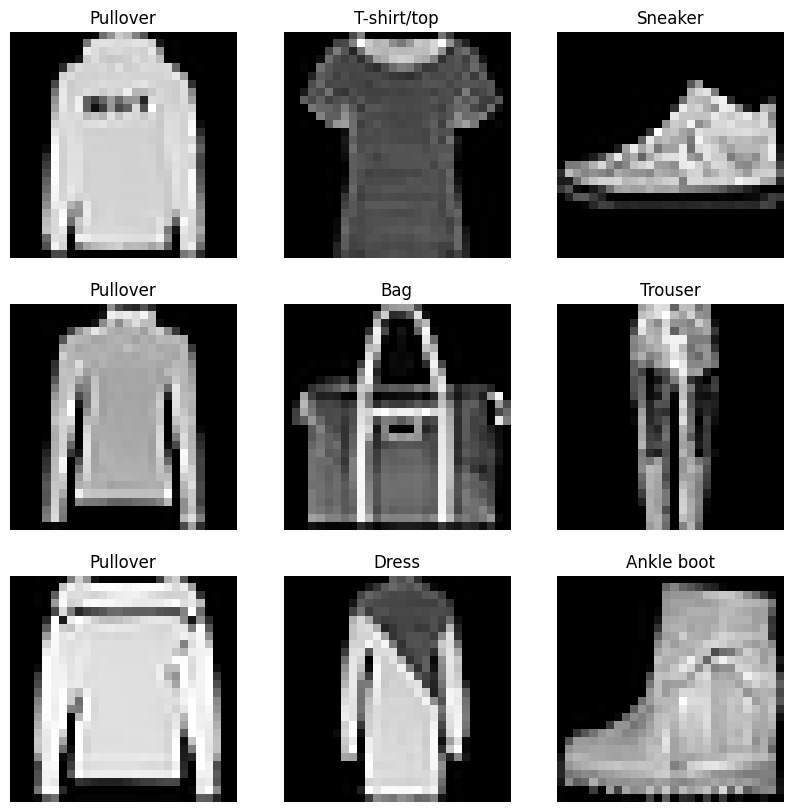

In [7]:
# Looking at a few random data points
fig = plt.figure(figsize = [10,10])
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low = 0, high = len(train_data), size = [1]).item()
    img, label_id = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(train_data.classes[label_id])
    plt.axis(False)

In [8]:
# Move to DataLoader
batch_size = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = batch_size * 2)   # Testing doesn't need gradients, more memory

In [9]:
# Number of batches
print(f"Length of the dataloader: {len(train_dataloader)}")
print()
print(f'{len(train_dataloader)} * {batch_size} = {len(train_dataloader) * batch_size}')
print()
print(f"Length of the dataset: {len(train_data)}")

Length of the dataloader: 1875

1875 * 32 = 60000

Length of the dataset: 60000


# Model

## Linear

In [10]:
# Creating a linear neural network
model_fmnist_linear = nn.Sequential(
    nn.Flatten(),                                       # Flattening image data for a linear nn
    nn.Linear(in_features = 28*28, out_features = 16),
    nn.Linear(in_features = 16, out_features = 16),
    nn.Linear(in_features = 16, out_features = 10)   
)

In [11]:
# Loss function, Optimizer, Evaluation Metric
loss_function = nn.CrossEntropyLoss()

optimizer_linear = torch.optim.SGD(params = model_fmnist_linear.parameters(),
                            lr = 0.01) 

eval_metric_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10)

In [12]:
print(f"Number of batches in the training dataloader: {len(train_dataloader)}")
print(f"Number of batches in the testing dataloader: {len(test_dataloader)}")

Number of batches in the training dataloader: 1875
Number of batches in the testing dataloader: 157


In [13]:
# For progress bar
from tqdm.auto import tqdm

# For training time
train_time_start = timer()

# Epochs
epochs = 3

# Training loop
for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch} \n ------------------- \n")
    
    ## Training
    train_loss_sum = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        model_fmnist_linear.train()
        
        y_pred = model_fmnist_linear(X)
        loss = loss_function(y_pred, y)
        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
        
        train_loss_sum += loss
        
        # Training update
        if batch % int(len(train_dataloader) / 5) == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")
    
    ## Testing
    test_loss_sum = 0
    test_accuracy_sum = 0
    
    for batch, (X, y) in enumerate(test_dataloader):
        model_fmnist_linear.eval()
        
        y_pred = model_fmnist_linear(X)
        
        test_loss_sum += loss_function(y_pred, y)
        
        test_accuracy_sum += eval_metric_accuracy(torch.argmax(y_pred, dim = 1).squeeze(), y)
    
    # Averaging
    train_loss_avg = train_loss_sum / len(train_dataloader)
    
    test_loss_avg = test_loss_sum / len(test_dataloader)
    test_accuracy_avg = test_accuracy_sum / len(test_dataloader)
    
    # Progress update
    print(f"\nEpoch: {epoch}  |  Loss: {train_loss_avg:.4f}  |  Test Loss: {test_loss_avg:.4f}  |  Test Accuracy: {test_accuracy_avg*100:.2f}%  |")
    
train_time_end = timer()

# Time taken update
print(f"\n\nTime taken by the {str(next(model_fmnist_linear.parameters()).device)} is {train_time_end - train_time_start} seconds.")

/home/abhayrokkam/projects/pytorch-ztm/.torch-ztm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0 
 ------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples


 33%|███▎      | 1/3 [00:06<00:13,  6.64s/it]


Epoch: 0  |  Loss: 0.9656  |  Test Loss: 0.6651  |  Test Accuracy: 76.66%  |

Epoch: 1 
 ------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples


 67%|██████▋   | 2/3 [00:13<00:06,  6.54s/it]


Epoch: 1  |  Loss: 0.5772  |  Test Loss: 0.5478  |  Test Accuracy: 80.78%  |

Epoch: 2 
 ------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples


100%|██████████| 3/3 [00:19<00:00,  6.46s/it]


Epoch: 2  |  Loss: 0.5037  |  Test Loss: 0.5104  |  Test Accuracy: 81.90%  |


Time taken by the cpu is 19.37281104900012 seconds.


## Non-Linear

In [14]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# Model with non-linear functions
model_fmnist_non_linear = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 28 * 28, out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 10),
    nn.ReLU()
).to(device)

In [16]:
# Loss function, optimizer and accuracy
loss_function = nn.CrossEntropyLoss()
optimizer_non_linear = torch.optim.SGD(params = model_fmnist_non_linear.parameters(),
                                       lr = 0.1)
accuracy_function = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10)

In [ ]:
# Function to train the model
def train_model_epoch(model: nn.Module,
                      dataloader: DataLoader,
                      loss_function: nn.Module,
                      optimizer: torch.optim.Optimizer,
                      device: torch.device) -> None:
    """
    A function to train the model on the training dataloader for one epoch.
    
    Args:
        model: Any torch model that subclasses nn.Module class.
        data_loader: A pytorch DataLoader for the evaluation.
        loss_function: Function to calculate the loss. From the torch.nn module.
        optimizer: An optimizer from the torch.optim library.
        device: Device to do the computations on.
    
    Returns:
        None
    """
    ## Training
    model.train()
    
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        model = model.to(device)
        
        # Forward -> Loss -> Zero Grad -> Backward -> Gradient Descent  
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
        
        # Training progress update
        if batch % int(len(dataloader) / 5) == 0:
            print(f"Looked at {batch * len(X)} / {len(dataloader.dataset)} samples")
    
    # Loss avg and print
    train_loss /= len(dataloader)
    print(f"\nTraining Loss: {train_loss:.2f}")

In [ ]:
# Function to test the model
def test_model_epoch(model: nn.Module,
                     dataloader: DataLoader,
                     loss_function: nn.Module,
                     accuracy_function: torchmetrics.Accuracy,
                     device: torch.device) -> None:
    """
    A function to test the model on the testing dataloader for one epoch.
    
    Args:
        model: Any torch model that subclasses nn.Module class.
        data_loader: A pytorch DataLoader for the evaluation.
        loss_function: Function to calculate the loss. From the torch.nn module.
        accuracy_function: Function to calculate the accuracy. From torchmetrics.Accuracy class.
        device: Device to do the computations on.
    
    Returns:
        None
    """
    ## Testing
    model.eval()
    
    test_loss = 0
    test_accuracy = 0
    
    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        model = model.to(device)
        accuracy_function = accuracy_function.to(device)
        
        y_pred = model(X)
        
        test_loss += loss_function(y_pred, y)
        test_accuracy += accuracy_function(torch.argmax(y_pred, dim = 1).squeeze(), y)
    
    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)
    
    # Test values
    print(f"\nTest Loss: {test_loss:.4f}  |  Test Accuracy: {test_accuracy*100:.2f}% ")

In [ ]:
# Function to evaluate model
def eval_model(model: nn.Module,
               dataloader: DataLoader,
               loss_function: nn.Module,
               accuracy_function: torchmetrics.Accuracy) -> dict:
    """
    A function to evaluate a pytorch model on the given dataset. Evaluation calculated loss and accuracy.H
    
    Args:
        model: Any torch model that subclasses nn.Module class.
        data_loader: A pytorch DataLoader for the evaluation.
        loss_function: Function to calculate the loss. From the torch.nn module.
        accuracy_function: Function to calculate the accuracy. From torchmetrics.Accuracy class.
    
    Returns:
        A dict item with model name, loss, accuracy.
    """
    loss = 0
    accuracy = 0
    
    # Set to evaluation
    model.eval()
    with torch.inference_mode():
        # Enumerate through the dataloader
        for _, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Make predictions
            y_pred = model(X)
                
            # Calculate loss and accuracy
            loss += loss_function(y_pred, y)
            accuracy += accuracy_function(torch.argmax(y_pred, dim = 1).squeeze(), y)
    
        # Average loss and accuracy
        loss /= len(dataloader)
        accuracy /= len(dataloader)
    
    return {'model_name': model.__class__.__name__,
            'loss': loss.item(),
            'accuracy': accuracy.item() * 100}

In [20]:
# Training and Testing
time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch} \n -------------------------------- \n")
    train_model_epoch(model = model_fmnist_non_linear,
                      dataloader = train_dataloader,
                      loss_function = loss_function,
                      optimizer = optimizer_non_linear,
                      device = device)
    test_model_epoch(model = model_fmnist_non_linear,
                     dataloader = test_dataloader,
                     loss_function = loss_function,
                     accuracy_function = accuracy_function,
                     device = device)
    
time_end = timer()

print(f"\nTotal time taken to run the code on cuda is {time_end - time_start} seconds.")

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0 
 -------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.85


 33%|███▎      | 1/3 [00:08<00:17,  8.93s/it]


Test Loss: 0.5267  |  Test Accuracy: 81.69% 

Epoch: 1 
 -------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.47


 67%|██████▋   | 2/3 [00:18<00:09,  9.40s/it]


Test Loss: 0.4549  |  Test Accuracy: 83.64% 

Epoch: 2 
 -------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.43


100%|██████████| 3/3 [00:28<00:00,  9.36s/it]


Test Loss: 0.4952  |  Test Accuracy: 82.23% 

Total time taken to run the code on cuda is 28.088739860000032 seconds.


In [21]:
# Evaluation
eval_model(model = model_fmnist_non_linear,
           dataloader = test_dataloader,
           loss_function = loss_function,
           accuracy_function = accuracy_function)

{'model_name': 'Sequential',
 'loss': 0.49517306685447693,
 'accuracy': 82.2253167629242}

## Convolutional

In [22]:
# Convolutional Model
class ConvolutionFMNISTModel(nn.Module):
    """
    A class to instantiate a CNN for the FashionMNIST dataset. 
    Replicates TinyVGG with the below shown architecture.
    
    {Conv -> Conv -> MaxPool} -> {Conv -> Conv -> MaxPool} -> {Flatten -> Linear}
    {Block 1}                 -> {Block 2}                 -> {Classifier}
    
    """
    def __init__(self) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                      out_channels = 10,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10,
                      out_channels = 10,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 10,
                      out_channels = 10,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 10,
                      out_channels = 10,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 10 * (7 * 7),     # 28 x 28 -> 14 x 14 -> 7 x 7 {Block1 input -> Block2 input -> Classifier input}
                      out_features = 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [23]:
# Instantiate the model
model_fmnist_convolution = ConvolutionFMNISTModel()

In [24]:
# Loss, optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_fmnist_convolution.parameters(),
                            lr = 0.1)
accuracy_function = torchmetrics.Accuracy(task = 'multiclass', num_classes = 10)

In [25]:
# Training and Testing
start_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch} ----------------------------------------- \n")
    train_model_epoch(model = model_fmnist_convolution,
                      dataloader = train_dataloader,
                      loss_function = loss_function,
                      optimizer = optimizer,
                      device = device)
    test_model_epoch(model = model_fmnist_convolution,
                     dataloader = test_dataloader,
                     loss_function = loss_function,
                     accuracy_function = accuracy_function,
                     device = device)

end_time = timer()

print(f"Time taken to train the convolutional model on {str(next(model_fmnist_convolution.parameters()).device)} is {end_time - start_time} seconds.")

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 0 ----------------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.68


 33%|███▎      | 1/3 [00:10<00:21, 10.89s/it]


Test Loss: 0.3876  |  Test Accuracy: 86.06% 

Epoch: 1 ----------------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.36


 67%|██████▋   | 2/3 [00:21<00:10, 10.79s/it]


Test Loss: 0.3450  |  Test Accuracy: 87.59% 

Epoch: 2 ----------------------------------------- 

Looked at 0 / 60000 samples
Looked at 12000 / 60000 samples
Looked at 24000 / 60000 samples
Looked at 36000 / 60000 samples
Looked at 48000 / 60000 samples

Training Loss: 0.33


100%|██████████| 3/3 [00:32<00:00, 10.70s/it]


Test Loss: 0.3389  |  Test Accuracy: 87.71% 
Time taken to train the convolutional model on cuda:0 is 32.11604596899997 seconds.


# Evaluation

In [26]:
# Evaluating the model results
eval_model(model=model_fmnist_convolution,
           dataloader=test_dataloader,
           loss_function=loss_function,
           accuracy_function=accuracy_function)

{'model_name': 'ConvolutionFMNISTModel',
 'loss': 0.3388558328151703,
 'accuracy': 87.70899772644043}

## Random samples from test dataset

In [57]:
# Function to return predictions given random sample data
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device) -> list:
    """
    A function that returns the predictions of a given model on sample data.
    
    Args:
        model: Any torch model that subclasses nn.Module class.
        data: List of specific number of data points in torch.tensor type.
            list(torch.tensor * k)  ->  k = number of samples
        device: Device for computations.
    
    Returns:
        The function returns a list object with prediction classes from the model.
        
        Example: [5, 8, 6, 4, 7]
            for k = 5, and num_classes = 10
    """
    preds = []
    model.eval()
    
    model = model.to(device)
    
    with torch.inference_mode():
        for sample in data:
            # Add batch dimension and move to device
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            # Make predicitons
            pred = model(sample)
            # Append the item to return list
            preds.append(torch.argmax(pred, dim = 1).cpu().item())
        
    return preds

In [67]:
import random

# Get random samples of data
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_preds = make_predictions(model=model_fmnist_convolution,
                                data=test_samples,
                                device=device)

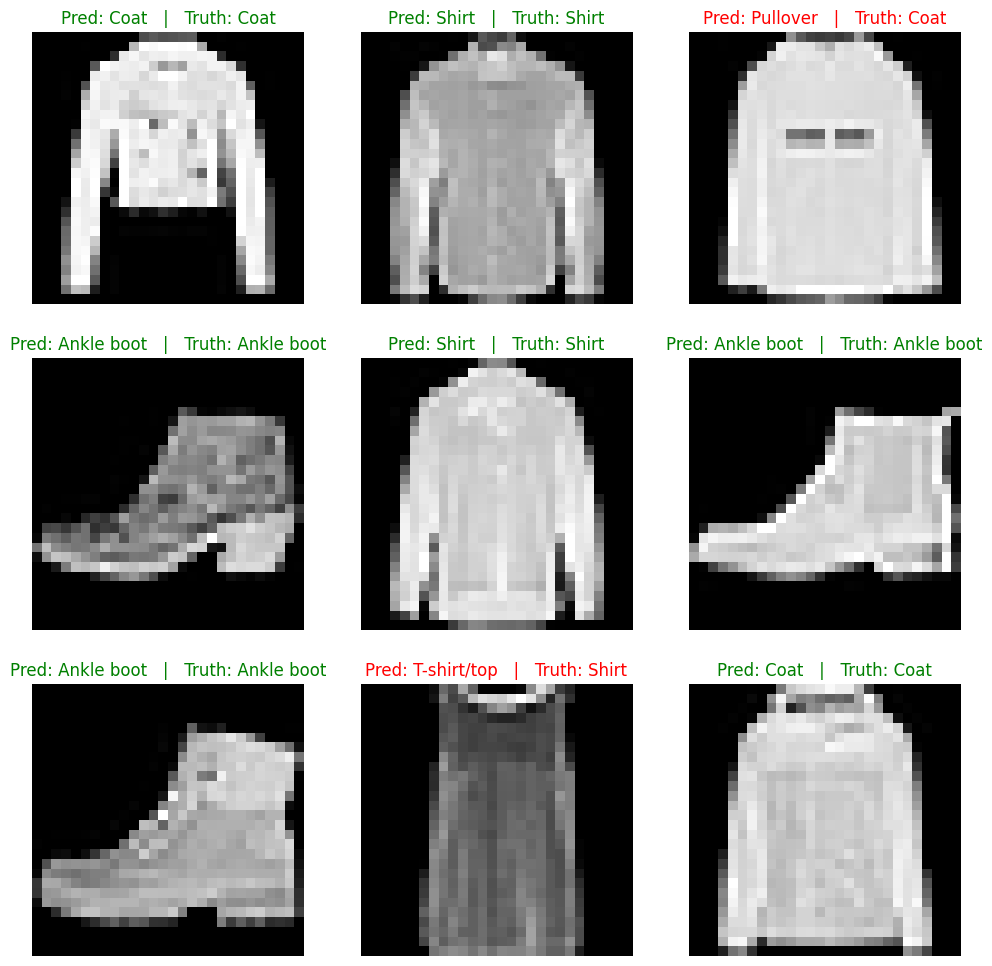

In [68]:
plt.figure(figsize = (12,12))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    
    plt.imshow(sample.squeeze(), cmap = 'gray')
    
    pred_label = train_data.classes[test_preds[i]]
    truth_label = train_data.classes[test_labels[i]] 
    
    title_text = f"Pred: {pred_label}   |   Truth: {truth_label}"
    
    if(pred_label == truth_label):
        plt.title(title_text, c="green")
    else:
        plt.title(title_text, c="r")

    plt.axis(False)

## Confusion Matrix

In [119]:
# Moving all the features of the test data to a list of torch.tensor 
test_data_X = list(map(lambda x: x[0], test_data))

# Making predictions from our model to the entire test dataset
test_preds = make_predictions(model=model_fmnist_convolution,
                              data=test_data_X,
                              device=device)

test_preds = torch.tensor(test_preds)
print(test_preds.shape)

torch.Size([10000])


In [120]:
# Initializing and computing confusion matrix
eval_metric_confusion_matrix = torchmetrics.ConfusionMatrix(task = 'multiclass',
                                                            num_classes = 10)

confusion_matrix = eval_metric_confusion_matrix(preds = test_preds,
                                                target = test_data.targets)

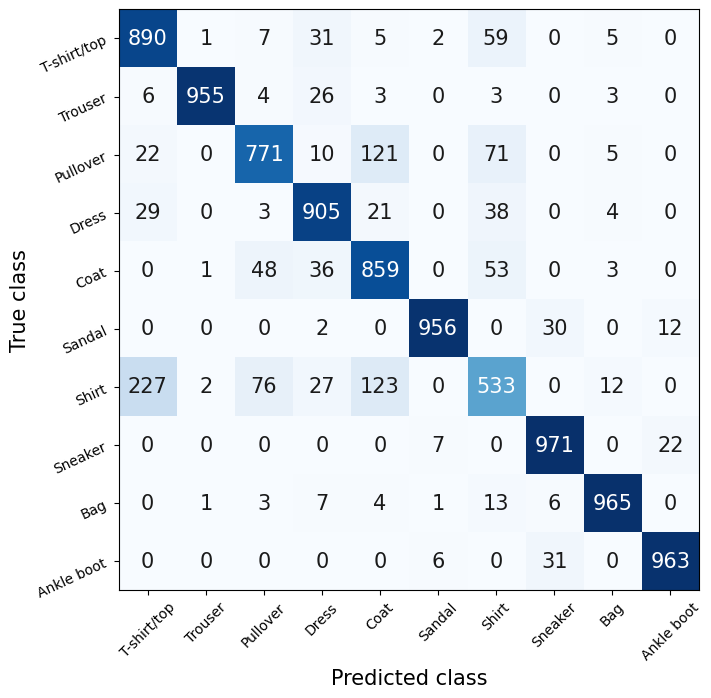

In [ ]:
# Plotting the confusion matrix
fig, ax = eval_metric_confusion_matrix.plot(cmap = plt.cm.Blues, 
                                            labels=test_data.classes)
fig.set_size_inches(7, 7)